In [102]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mimg

### E-commerce data
Анонимизированные данные о электронных продажах, хранятся в виде объединенного CSV файла

Скачать можно здесь: https://www.kaggle.com/carrie1/ecommerce-data/data#

В качестве OLAP cube бэкэнда использовался python-фреймворк cubes: http://cubes.databrewery.org/


## 1. Подготовка данных

In [103]:
df = pd.read_csv('./data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [104]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [106]:
# для упрощения работы переименуем столбцы согласно python naming convention (не обязательно, но потом будет проще маппить)
df = df.rename(columns={
    "InvoiceNo": "invoice_number",
    "Quantity": "quantity",
    "StockCode": "stock_code",
    "Description": "description",
    "UnitPrice": "unit_price",
    "CustomerID": "customer",
    "Country": "country",
    "InvoiceDate": "invoice_date",
    "Price": "price"
})

In [107]:
# фикс типа данных для даты
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [108]:
# Разделяем дату на значения дня, месяца и года
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df['day'] = df['invoice_date'].dt.day

In [109]:
# удаляем старую дату
df = df.drop(columns=['invoice_date'])

In [110]:
df.head()

,invoice_number,stock_code,description,quantity,unit_price,customer,country,year,month,day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010,12,1


### Очистка пустых значений

Пустые значения ID-шников могут привести к проблемам в маппинге, поэтому их необходимо удалить

In [111]:
for column in df.columns:
    print(f'{column} {df[column].isna().sum()}')

invoice_number 0
stock_code 0
description 1454
quantity 0
unit_price 0
customer 135080
country 0
year 0
month 0
day 0


Нет возможности заполнить пустые ID заказчика или описание товара каким-либо правильным значением, так что строки с пустыми значениями должны быть просто удалены

In [112]:
df = df.dropna(axis=0)

In [113]:
for column in df.columns:
    print(f'{column} {df[column].isna().sum()}')

invoice_number 0
stock_code 0
description 0
quantity 0
unit_price 0
customer 0
country 0
year 0
month 0
day 0


### Выносим данные о товарах в отдельную таблицу

Т.к. OLAP cube оперирует понятиями "dimension table" и "fact table", данные о сущностях должны быть вынесены в отдельную таблицу, если это возможно.
В данном случае в отдельную таблицу будет вынесена информация о продукте, оставшаяся основная таблица будет служить в качестве dimension table

In [114]:
df_product = df[['stock_code', 'description', 'unit_price']].drop_duplicates()

In [115]:
len(df_product)

9206

In [116]:
df_product[df_product.duplicated(subset=['description'], keep=False)]

,stock_code,description,unit_price
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39
...,...,...,...
540066,23535,WALL ART BICYCLE SAFETY,3.90
540068,23526,WALL ART DOG LICENCE,3.90
540272,21253,SET OF PICTURE FRAME STICKERS,0.79
541541,M,Manual,224.69


Похоже, что цена каждого отдельного товара изменяется в зависимости от времени. Для упрощения вычислений оставим только начальные цены.
Для маппинга необходимо исправить неправильные stock codes

In [117]:
df_product = df_product.drop_duplicates(subset=['description'], keep='first')

In [118]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3896 entries, 0 to 540421
Data columns (total 3 columns):
stock_code     3896 non-null object
description    3896 non-null object
unit_price     3896 non-null float64
dtypes: float64(1), object(2)
memory usage: 121.8+ KB


In [119]:
# create mapping dictionary
stock_code_mapping = {}

for index, row in df_product.iterrows():
    stock_code_mapping[row['description']] = row['stock_code']

In [120]:
def stock_code_fix(row):
    return stock_code_mapping[row['description']]

In [121]:
df['stock_code'] = df.apply(lambda row: stock_code_fix(row), axis=1)

In [122]:
df_product.head()

,stock_code,description,unit_price
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39


In [123]:
# удаляем все строки с неуникальным stock_code
df_product = df_product.drop_duplicates(subset=['stock_code'], keep='first')

In [124]:
df = df.drop(columns=['description', 'unit_price'])

In [125]:
df.head()

,invoice_number,stock_code,quantity,customer,country,year,month,day
0,536365,85123A,6,17850,United Kingdom,2010,12,1
1,536365,71053,6,17850,United Kingdom,2010,12,1
2,536365,84406B,8,17850,United Kingdom,2010,12,1
3,536365,84029G,6,17850,United Kingdom,2010,12,1
4,536365,84029E,6,17850,United Kingdom,2010,12,1


### Удаляем ненужные данные 

In [126]:
df = df.drop(columns=["invoice_number"])

In [127]:
df.head()

,stock_code,quantity,customer,country,year,month,day
0,85123A,6,17850,United Kingdom,2010,12,1
1,71053,6,17850,United Kingdom,2010,12,1
2,84406B,8,17850,United Kingdom,2010,12,1
3,84029G,6,17850,United Kingdom,2010,12,1
4,84029E,6,17850,United Kingdom,2010,12,1


In [128]:
df_product.head()

,stock_code,description,unit_price
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39


## 2. Перенос данных в БД

### Сохраняем данные в базу 

В качестве базы используется sqlite, но sqlalchemy поддерживает mysql, postgress и прочие СУБД

In [129]:
from sqlalchemy import create_engine

In [131]:
import sqlite3

In [94]:
os.remove('./data.sqlite')

In [132]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Exception as e:
        print(e)
 
    return conn

In [133]:
conn = create_connection('./data.sqlite')

Создадим структуру данных:

In [134]:
# кастомизация сохранения данных в таблицах

def create_table(conn, create_table_sql):
    """
    create SQLite table using specified sql code
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Exception as e:
        print(e)

In [135]:
sql_create_products_table = """
CREATE TABLE IF NOT EXISTS products (
    stock_code text PRIMARY KEY,
    description text NOT NULL,
    unit_price float NOT NULL
);
"""


sql_create_sales_table = """
CREATE TABLE IF NOT EXISTS sales (
    id integer PRIMARY KEY,
    stock_code text NOT NULL,
    quantity integer NOT NULL,
    customer text NOT NULL,
    country text NOT NULL,
    year integer NOT NULL,
    month integer NOT NULL,
    day integer NOT NULL,
    FOREIGN KEY (stock_code) REFERENCES products (stock_code)
);
"""

In [136]:
create_table(conn, sql_create_products_table)

In [137]:
create_table(conn, sql_create_sales_table)

In [138]:
# сохраняем данные из датасета в базу данных

engine = create_engine('sqlite:///data.sqlite')

main_table_name = "sales"
product_table_name = "products"

df_product.to_sql(product_table_name, if_exists="append", index=False, con=engine)
df.to_sql(main_table_name, con=engine, if_exists="append", index_label='id')

### Выведем структуру базы

In [139]:
from eralchemy import render_er

In [140]:
render_er("sqlite:///data.sqlite", './erd_from_sqlite.png')

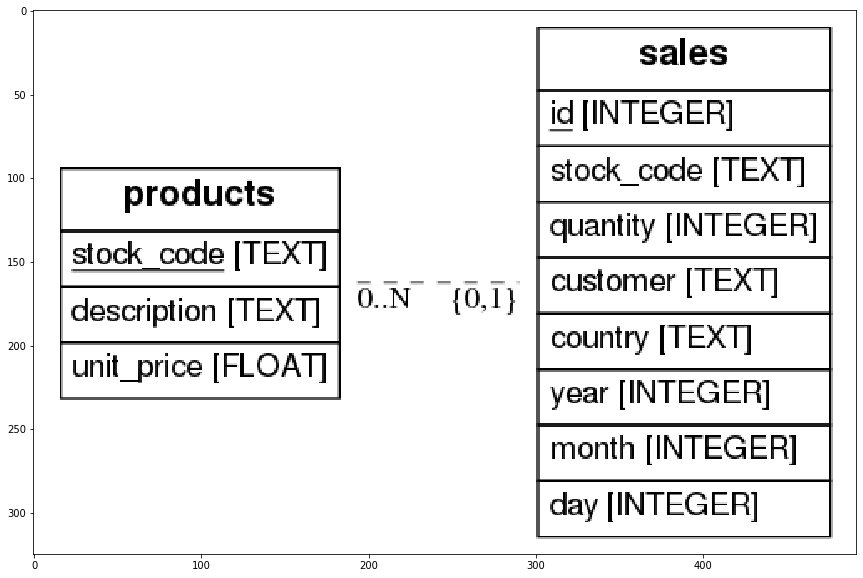

In [141]:
fig, ax = plt.subplots(figsize=(18, 10))
img = mimg.imread('./erd_from_sqlite.png')
ax.imshow(img)

## 3. Проверка работы Cubes

### Запускаем сервис

Для запуска сервиса необходимо запустить в терминале команду 
```bash
slicer serve slicer.ini
```

In [154]:
# подключаем библиотеку requests для web-запросов
import requests

### Проверяем работу аггрегации

In [148]:
# соберем цены товаров для быстрого вычисления цены корзины

prices_mapping = {}

for index, row in df_product.iterrows():
    prices_mapping[row['stock_code']] = row['unit_price']

1. Общее количество товаров, проданых за 2010:

In [153]:
# аггрегация с помощью pandas
df[df['year']==2010]['quantity'].sum()

296362

In [158]:
# аггрегация с помощью cubes
response = requests.get('http://localhost:5000/cube/sales/aggregate?cut=year:2010')
response.json()['summary']['quantity_total']

296362

2. Общая сумма товаров, проданная за январь 2011:

In [160]:
# аггрегация с помощью pandas
price_total = 0
subset = df[(df['year']==2011) & (df['month']==1)]
for index, row in subset.iterrows():
    price_total += row['quantity']*prices_mapping[row['stock_code']]
    
price_total

522575.3600000128

In [161]:
# аггрегация с помощью cubes
response = requests.get('http://localhost:5000/cube/sales/aggregate?cut=year:2011|month:1')
response.json()['summary']['price_total']

522575.3600000128

3. Средняя цена корзины 1 февраля 2011

In [163]:
# аггрегация с помощью pandas
price_total = 0
count = 0
subset = df[(df['year']==2011) & (df['month']==2) & (df['day']==1)]
for index, row in subset.iterrows():
    price_total += row['quantity']*prices_mapping[row['stock_code']]
    count += 1
price_total / count

21.521592709984176

In [164]:
# аггрегация с помощью cubes
response = requests.get('http://localhost:5000/cube/sales/aggregate?cut=year:2011|month:2|day:1')
response.json()['summary']['price_avg']

21.521592709984176